# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) or [here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

Please make sure if you are running this notebook in the workspace that you have chosen GPU rather than CPU mode.

In [1]:
# Standard library imports.
import json
import time
from os.path import join

# Related third party imports.
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from collections import OrderedDict

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = r'D:\Flowers'
train_dir = join(data_dir,'train')
valid_dir = join(data_dir,'valid')
test_dir = join(data_dir,'test')

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(25),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
    ]),
    'test':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
    ]),
}

In [4]:
# TODO: Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(join(data_dir,x),data_transforms[x])
                  for x in ['train','valid','test']}

In [5]:
# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {
    'train':torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, shuffle=True),
    'valid':torch.utils.data.DataLoader(image_datasets['valid'], batch_size=32, shuffle=False),
    'test':torch.utils.data.DataLoader(image_datasets['test'], batch_size=32, shuffle=False)
}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

In [7]:
# Transfer pre-trained model and freeze the parameters.
def TransferModel(arch):
    if arch == 'VGG':
        model = models.vgg16(pretrained=True)
    elif arch == 'AlexNet':
        model = models.alexnet(pretrained=True)
    elif arch == 'ResNet':
        model = models.resnet18(pretrained=True)
    elif arch == 'DenseNet':
        model = models.densenet121(pretrained=True)

    # Freeze the parameter
    for param in model.parameters():
        param.requires_grad = False

    return model

In [8]:
# Get number of features of model.
def GetInputFeatures(model):
    if hasattr(model, "classifier"):
        try:
            input_size = model.classifier[0].in_features
        except TypeError:
            input_size = model.classifier.in_features
    elif hasattr(model, "fc"):
        input_size = model.fc.in_features
    return input_size

In [9]:
# Build a classifier based on a pre-trained model.
def BuildClassifier(arch,ouput_size,hidden_units):
    model = TransferModel(arch)
    input_size = GetInputFeatures(model)
    classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(input_size, hidden_units[0])),
        ('relu1', nn.ReLU()),
        ('dropout',nn.Dropout(0.1)),
        ('fc2', nn.Linear(hidden_units[0], hidden_units[1])),
        ('relu2', nn.ReLU()),
        ('fc3', nn.Linear(hidden_units[1], ouput_size)),
        ('output', nn.LogSoftmax(dim=1))
    ]))
    model.classifier = classifier
    return model

In [10]:
arch = 'DenseNet'
input_size = 1024
hidden_units = [512, 256]
output_size = 102
model = BuildClassifier(arch,output_size,hidden_units)

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [11]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [12]:
# Validation the model
def validation(model, testloader, criterion):
    model.eval()
    test_loss = 0
    accuracy = 0

    device = 'cuda'
    model.to(device)

    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        
        with torch.no_grad():
            output = model.forward(images)
            test_loss += criterion(output, labels).item()
            
            ps = torch.exp(output)
            equality = (labels.data == ps.max(dim=1)[1])
            accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [13]:
# Train the model
def do_deep_learning(model, dataloaders, epochs, print_every, criterion, optimizer):
    steps = 0

    device = 'cuda'
    model.to(device)

    for e in range(epochs):
        running_loss = 0
        for ii, (inputs, labels) in enumerate(dataloaders['train']):
            steps += 1

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward and backward passes
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                valid_loss, valid_accuracy = validation(model, dataloaders['valid'], criterion)
                print("Epoch: {}/{}... ".format(e+1, epochs),
                      "Training Loss: {:.4f}".format(running_loss/print_every),
                      "Validation Loss: {:.4f}".format(valid_loss/len(dataloaders['valid'])),
                      "Validation Accuracy: {:.2f}%".format(100*valid_accuracy/len(dataloaders['valid'])))

                running_loss = 0
                
                # Continue to train
                model.train()

In [14]:
do_deep_learning(model, dataloaders, 30, 10, criterion, optimizer)

Epoch: 1/30...  Training Loss: 4.5252 Validation Loss: 4.4461 Validation Accuracy: 8.17%
Epoch: 1/30...  Training Loss: 4.3803 Validation Loss: 4.2291 Validation Accuracy: 12.62%
Epoch: 1/30...  Training Loss: 4.1367 Validation Loss: 3.9107 Validation Accuracy: 20.07%
Epoch: 1/30...  Training Loss: 3.8119 Validation Loss: 3.5710 Validation Accuracy: 23.08%
Epoch: 1/30...  Training Loss: 3.5718 Validation Loss: 3.1307 Validation Accuracy: 36.82%
Epoch: 1/30...  Training Loss: 3.2176 Validation Loss: 2.7025 Validation Accuracy: 42.40%
Epoch: 1/30...  Training Loss: 2.8052 Validation Loss: 2.4023 Validation Accuracy: 41.77%
Epoch: 1/30...  Training Loss: 2.6520 Validation Loss: 2.2257 Validation Accuracy: 44.34%
Epoch: 1/30...  Training Loss: 2.3829 Validation Loss: 2.0577 Validation Accuracy: 50.48%
Epoch: 1/30...  Training Loss: 2.1758 Validation Loss: 1.6620 Validation Accuracy: 62.10%
Epoch: 2/30...  Training Loss: 1.2641 Validation Loss: 1.4279 Validation Accuracy: 65.20%
Epoch: 2/30

Epoch: 10/30...  Training Loss: 0.1281 Validation Loss: 0.3178 Validation Accuracy: 91.25%
Epoch: 10/30...  Training Loss: 0.4918 Validation Loss: 0.3138 Validation Accuracy: 91.97%
Epoch: 10/30...  Training Loss: 0.5552 Validation Loss: 0.3329 Validation Accuracy: 90.77%
Epoch: 10/30...  Training Loss: 0.4826 Validation Loss: 0.3447 Validation Accuracy: 90.44%
Epoch: 10/30...  Training Loss: 0.6121 Validation Loss: 0.3419 Validation Accuracy: 89.69%
Epoch: 10/30...  Training Loss: 0.4907 Validation Loss: 0.3483 Validation Accuracy: 90.53%
Epoch: 10/30...  Training Loss: 0.5613 Validation Loss: 0.3226 Validation Accuracy: 90.95%
Epoch: 10/30...  Training Loss: 0.4555 Validation Loss: 0.3599 Validation Accuracy: 89.33%
Epoch: 10/30...  Training Loss: 0.4273 Validation Loss: 0.3275 Validation Accuracy: 89.81%
Epoch: 10/30...  Training Loss: 0.4578 Validation Loss: 0.2990 Validation Accuracy: 90.41%
Epoch: 10/30...  Training Loss: 0.4225 Validation Loss: 0.2873 Validation Accuracy: 91.85%

Epoch: 18/30...  Training Loss: 0.3576 Validation Loss: 0.2646 Validation Accuracy: 93.30%
Epoch: 18/30...  Training Loss: 0.3794 Validation Loss: 0.2385 Validation Accuracy: 93.44%
Epoch: 19/30...  Training Loss: 0.2268 Validation Loss: 0.2559 Validation Accuracy: 92.82%
Epoch: 19/30...  Training Loss: 0.4126 Validation Loss: 0.2471 Validation Accuracy: 93.42%
Epoch: 19/30...  Training Loss: 0.3413 Validation Loss: 0.2851 Validation Accuracy: 93.18%
Epoch: 19/30...  Training Loss: 0.3369 Validation Loss: 0.2726 Validation Accuracy: 93.54%
Epoch: 19/30...  Training Loss: 0.4306 Validation Loss: 0.2617 Validation Accuracy: 93.18%
Epoch: 19/30...  Training Loss: 0.3977 Validation Loss: 0.2750 Validation Accuracy: 93.06%
Epoch: 19/30...  Training Loss: 0.3435 Validation Loss: 0.2664 Validation Accuracy: 93.90%
Epoch: 19/30...  Training Loss: 0.3490 Validation Loss: 0.2880 Validation Accuracy: 92.57%
Epoch: 19/30...  Training Loss: 0.4130 Validation Loss: 0.3170 Validation Accuracy: 92.63%

Epoch: 27/30...  Training Loss: 0.3039 Validation Loss: 0.2589 Validation Accuracy: 93.54%
Epoch: 27/30...  Training Loss: 0.3633 Validation Loss: 0.2649 Validation Accuracy: 93.66%
Epoch: 27/30...  Training Loss: 0.3357 Validation Loss: 0.2799 Validation Accuracy: 92.55%
Epoch: 27/30...  Training Loss: 0.3621 Validation Loss: 0.2664 Validation Accuracy: 93.06%
Epoch: 28/30...  Training Loss: 0.3341 Validation Loss: 0.2790 Validation Accuracy: 93.03%
Epoch: 28/30...  Training Loss: 0.3108 Validation Loss: 0.2909 Validation Accuracy: 93.30%
Epoch: 28/30...  Training Loss: 0.3859 Validation Loss: 0.2503 Validation Accuracy: 93.66%
Epoch: 28/30...  Training Loss: 0.3367 Validation Loss: 0.2557 Validation Accuracy: 92.69%
Epoch: 28/30...  Training Loss: 0.3135 Validation Loss: 0.2436 Validation Accuracy: 93.27%
Epoch: 28/30...  Training Loss: 0.3756 Validation Loss: 0.2371 Validation Accuracy: 94.26%
Epoch: 28/30...  Training Loss: 0.3676 Validation Loss: 0.2352 Validation Accuracy: 94.23%

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [15]:
# TODO: Do validation on the test set
def check_accuracy_on_test(testloader):    
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

In [16]:
check_accuracy_on_test(dataloaders['test'])

Accuracy of the network on the test images: 93 %


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [17]:
# TODO: Save the checkpoint
def SaveCheckPoint(model,arch,dataset,input_size,output_size,hidden_units,optimizer,save_dir):
    model.eval()
    model.class_to_idx = dataset.class_to_idx
    checkpoint = {
        'arch': arch,
        'input_size': input_size,
        'output_size': output_size,
        'hidden_units':hidden_units,
        'state_dict': model.state_dict(),
        'class_to_idx': model.class_to_idx,
        'optimizer': optimizer}
    torch.save(checkpoint, save_dir)

In [18]:
SaveCheckPoint(model, arch, image_datasets['train'], input_size, output_size, hidden_units, optimizer, 'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [19]:
# Load checkpoint and rebuild model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    
    arch = checkpoint['arch']
    output_size = checkpoint['output_size']
    hidden_units = checkpoint['hidden_units']
    model = BuildClassifier(arch,output_size,hidden_units)
    
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    model.optimizer = checkpoint['optimizer']
    
    return model

In [20]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
model = load_checkpoint('checkpoint.pth')

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [21]:
# Image pre-processing
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # TODO: Process a PIL image for use in a PyTorch model
    pil_image = Image.open(image)
    width, height = pil_image.size
    if width>height:
        pil_image.thumbnail([(width/height)*255,255])
    else:
        pil_image.thumbnail([255,(height/width)*255])
    new_w,new_h = pil_image.size
    pil_image = pil_image.crop(((new_w-224)/2,(new_h-224)/2,(new_w+224)/2,(new_h+224)/2))

    np_image = np.array(pil_image)
    np_image = np.divide(np_image,255)
    
    # Normalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    np_image = (np_image-mean)/std
    
    
    np_image = np_image.transpose((2,0,1))

    return torch.from_numpy(np_image)

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [22]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [23]:
# Class Prediction
def predict(image_path, model, topk, run_on_gpu):
    '''
    Predict the class (or classes) of an image using a trained deep learning model.
    '''
    if torch.cuda.is_available() and run_on_gpu==True:
        device = 'cuda'
    else:
        device = 'cpu'

    model.to(device)
    model.eval()
    images = process_image(image_path)
    images.unsqueeze_(0)

    images = images.to(device,dtype=torch.float)

    with torch.no_grad():
        output = model(images)
    probs, classes_index = output.data.topk(topk)
    probs = torch.exp(probs)
    
    classes = []
    index_to_class = {val: key for key, val in model.class_to_idx.items()}
    for index in classes_index[0].cpu().data.numpy():
        classes.append(str(index_to_class[index]))
    return probs[0].cpu().data.numpy(), classes

In [24]:
# Test the predict function
path = data_dir + '/test' + '/91/image_04875.jpg'
probs,classes = predict(path, model, 5, run_on_gpu=True)
print(probs)
print(classes)

[9.9918401e-01 5.6843058e-04 6.8847461e-05 6.4088912e-05 5.9066144e-05]
['91', '43', '80', '83', '89']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [25]:
def NameConversion(classes,dic_path):
    with open(dic_path, 'r') as f:
        cat_to_name = json.load(f)

    class_name=[]
    for aclass in classes:
        class_name.append(cat_to_name[aclass])
    return class_name

In [26]:
# Convert label to name
path = join(data_dir,'test','91','image_04875.jpg')
probs,classes = predict(path, model, 5, run_on_gpu=True)
ClassName = NameConversion(classes,'cat_to_name.json')

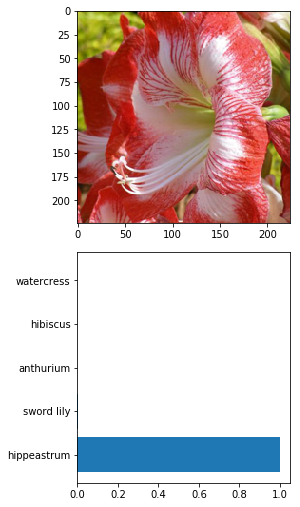

In [27]:
# Sanity Checking
fig, (img_ax, p_ax) = plt.subplots(figsize=(4,7), nrows=2)
img_ax = imshow(process_image(path), ax=img_ax)
p_ax.barh(ClassName, probs)
fig.tight_layout(pad=0.1, h_pad=0)

In [28]:
# Another Sanity Checking
path = join(data_dir,'test','16','image_06657.jpg')
probs,classes = predict(path, model, 5, run_on_gpu=True)
ClassName = NameConversion(classes,'cat_to_name.json')

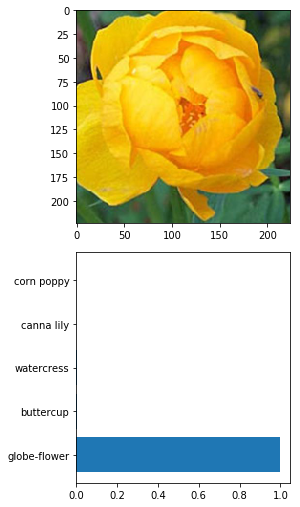

In [29]:
# Sanity Checking2
fig, (img_ax, p_ax) = plt.subplots(figsize=(4,7), nrows=2)
img_ax = imshow(process_image(path), ax=img_ax)
p_ax.barh(ClassName, probs)
fig.tight_layout(pad=0.1, h_pad=0)